## Loading Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from scipy import stats

In [ ]:
data = pd.read_csv('data/interaction_data.csv')

In [ ]:
ID_job = {}
for _, row in data.iterrows():
    ID_job[row['ID1']] = row['type1']
    ID_job[row['ID2']] = row['type2']
assert len(ID_job.keys())==75, 'wrong number of IDs'

In [ ]:
data = data.drop(columns = ['type1', 'type2'])
data['time'] = data['time']//60

In [ ]:
# map every ID to an index
nurses = []
doctors = []
patients = []
admins = []
ID_idx = {}
idx_ID = {}
idx_job = {}
for i, j in enumerate(list(ID_job.keys())):
    ID_idx[j] = i
    idx_ID[i] = j
    idx_job[i] = ID_job[j]
    if ID_job[j] == 1:
        nurses.append(i)
    if ID_job[j] == 2:
        patients.append(i)
    if ID_job[j] == 3:
        doctors.append(i)
    if ID_job[j] == 4:
        admins.append(i)

## Plotting Histogram

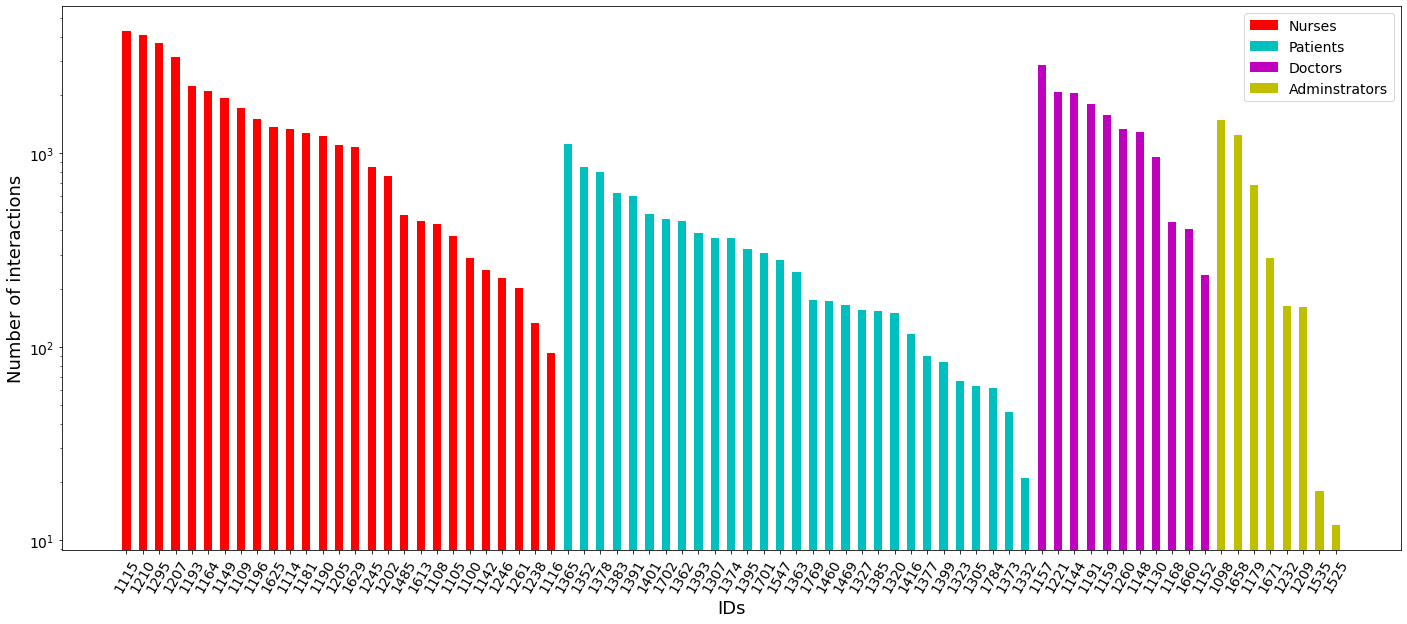

In [ ]:
hist_data = data.values[:, 0:2].reshape(-1,1)
IDs, interactions = np.unique(hist_data, return_counts=1)
jobs = np.array([ID_job[i] for i in IDs])
sorted_index = np.argsort(jobs)
IDs = IDs[sorted_index]
interactions = interactions[sorted_index]
jobs = jobs[sorted_index]

nurses_IDs = IDs[jobs==1]
nurses_ints = interactions[jobs==1]
patients_IDs = IDs[jobs==2]
patients_ints = interactions[jobs==2]
docs_IDs = IDs[jobs==3]
docs_ints = interactions[jobs==3]
admins_IDs = IDs[jobs==4]
admins_ints = interactions[jobs==4]

nurses_IDs = nurses_IDs[np.argsort(nurses_ints)[::-1]]
nurses_ints = nurses_ints[np.argsort(nurses_ints)[::-1]]
patients_IDs = patients_IDs[np.argsort(patients_ints)[::-1]]
patients_ints = patients_ints[np.argsort(patients_ints)[::-1]]
docs_IDs = docs_IDs[np.argsort(docs_ints)[::-1]]
docs_ints = docs_ints[np.argsort(docs_ints)[::-1]]
admins_IDs = admins_IDs[np.argsort(admins_ints)[::-1]]
admins_ints = admins_ints[np.argsort(admins_ints)[::-1]]

nurses_end = len(nurses_IDs)
patients_end = nurses_end + len(patients_IDs)
docs_end = patients_end + len(docs_IDs)
admins_end = docs_end + len(admins_IDs)

plt.figure(figsize=(24,10))
int_color = {1:'r', 2:'c', 3:'m', 4:'y'}
plt.bar(range(nurses_end), nurses_ints, align='center', width=0.5,
        color='r', label='Nurses')
plt.bar(range(nurses_end,patients_end), patients_ints, align='center', width=0.5,
        color='c', label='Patients')
plt.bar(range(patients_end,docs_end), docs_ints, align='center', width=0.5,
        color='m', label='Doctors')
plt.bar(range(docs_end,admins_end), admins_ints, align='center', width=0.5,
        color='y', label='Adminstrators')
plt.xticks(range(admins_end),
           np.concatenate((nurses_IDs, patients_IDs, docs_IDs, admins_IDs)),
           rotation=60,
           fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('IDs', fontsize=18)
plt.ylabel('Number of interactions', fontsize=18)
plt.yscale('log')
plt.legend(fontsize=14)
plt.show()

## Violin plots

In [ ]:
beta=0.0012
with open(f'results/remove_32/final_state_{beta}.pkl', 'rb') as f:  # replace remove32 with other experiments 
    final_state = pickle.load(f)
print(len(final_state))

In [ ]:
nurses_sus = []
docs_sus = []
pats_sus = []
admins_sus = []
all_sus = []
for fs in final_state:
  # if np.sum(fs==0) < 0.9 * 75:   # Uncomment this line to include propagating trials only
    nurses_sus.append(1-(np.sum(fs[nurses]==0)/(len(nurses)-3)))
    docs_sus.append(1-(np.sum(fs[doctors]==0)/(len(doctors)-2)))
    pats_sus.append(1-(np.sum(fs[patients]==0)/len(patients)))
    admins_sus.append(1-(np.sum(fs[admins]==0)/len(admins)))
    all_sus.append(1-(np.sum(fs==0)/len(fs)))

In [ ]:
nurses_baseline = np.mean(nurses_sus)
docs_baseline = np.mean(docs_sus)
pats_baseline = np.mean(pats_sus)
admins_baseline = np.mean(admins_sus)
all_baseline = np.mean(all_sus)

In [ ]:
trials = len(nurses_sus)
df = pd.DataFrame({'Number of Susceptibles':all_sus+nurses_sus+pats_sus,
                   'Job':['All']*trials+['Nurses']*trials+['Patients']*trials})

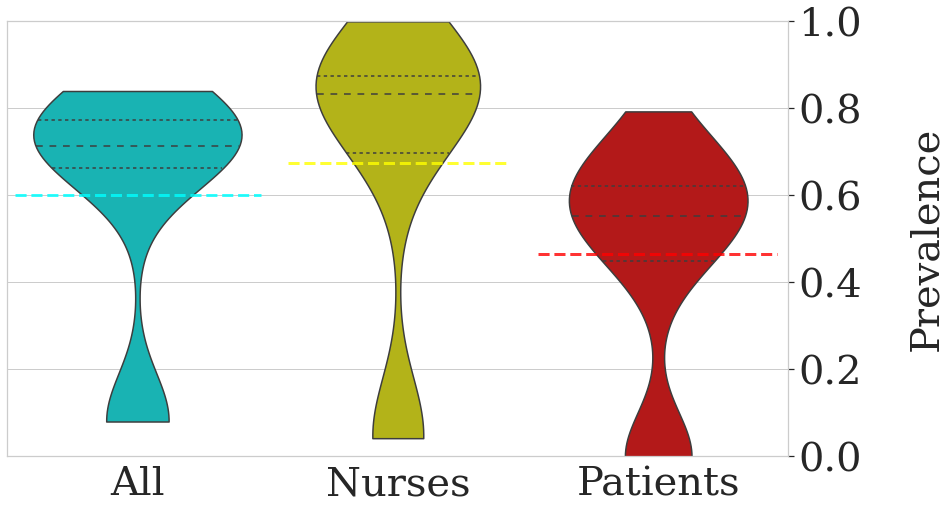

In [ ]:
plt.figure(figsize=(14,8))
hfont = {'fontname':'serif', 'fontsize':40}
sns.set(style="whitegrid")
palette={'All':(0,1,1), 'Nurses':(1,1,0), 'Patients':(1,0,0)}
palette2={'All':(0,0.8,0.8), 'Nurses':(0.8,0.8,0), 'Patients':(0.8,0,0)}

ax = sns.violinplot(x="Job", y="Number of Susceptibles", data=df, cut=0, palette=palette2, inner='quartile')
plt.xticks(**hfont)
plt.xlabel('')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.xlabel('')
plt.ylabel("\nPrevalence", **hfont, rotation=90)
plt.yticks(**hfont)

plt.axhline(y=all_baseline, color=palette['All'], linestyle='--', label='All', xmin=0.01, xmax=0.325, lw=3, alpha=0.8)
plt.axhline(y=nurses_baseline, color=palette['Nurses'], linestyle='--', label='Nurses', xmin=0.36, xmax=0.64, lw=3, alpha=0.8)
plt.axhline(y=pats_baseline, color=palette['Patients'], linestyle='--', label='Patients', xmin=0.68, xmax=0.985, lw=3, alpha=0.8)
plt.ylim(0,1)
plt.show()

## Stats calculations

### Mean R0 and Susceptible

In [ ]:
beta=0.0012
scenario = 'baseline'
with open(f'results/{scenario}/final_state_{beta}.pkl', 'rb') as f:
    fs_1 = pickle.load(f)
final_state = np.array(fs_1)
with open(f'results/{scenario}/R0_{beta}.pkl', 'rb') as f:
    R0_1 = pickle.load(f)
R0 = np.array(R0_1)

In [ ]:
sus = np.array([np.sum(fs==0) for fs in final_state])

In [ ]:
pop_count = {'baseline':75, 'Experiment3':75, 'remove_5':70, 'remove_top':70, 'remove_32':70}
proportion = 1.1
sus_epi = sus[~(sus >= proportion*pop_count[scenario])]
R0_epi = R0[~(sus >= proportion*pop_count[scenario])]

In [ ]:
print(f'Susceptible mean = {np.mean(sus_epi)}')
print(f'Susceptible std = {stats.sem(sus_epi)}')

Susceptible mean = 34.76
Susceptible std = 2.166136065565932


In [ ]:
print(f'R0 mean = {np.mean(R0_epi)}')
print(f'R0 std = {stats.sem(R0_epi)}')

R0 mean = 2.818619047619048
R0 std = 0.2285626135164877


### P-value

##### T10

In [ ]:
def run_permutation_test(x,y,num_samples):
  delta = np.mean(x) - np.mean(y)
  estimates = []
  for _ in range(num_samples):
    pooled = np.hstack([x,y])
    # np.random.shuffle(pooled)
    pooled = np.random.choice(pooled, size=pooled.shape, replace=True)
    starX = pooled[:len(x)]
    starY = pooled[-len(y):]
    estimates.append(starX.mean() - starY.mean())
  diffCount = len(np.where(estimates <=delta)[0])
  return ((diffCount)/(num_samples))

In [ ]:
pop_count = {'baseline':75, 'Experiment3':75, 'remove_5':70, 'remove_top':70, 'remove_32':70}
T10_vecs = {}
beta=0.0012
for scenario in pop_count.keys():
  with open(f'results/{scenario}/observations_{beta}.pkl', 'rb') as f:
      observations = pickle.load(f)

  with open(f'results/{scenario}/final_state_{beta}.pkl', 'rb') as f:
      fs_1 = pickle.load(f)
  final_state = np.array(fs_1)

  proportion = 0.9
  sus = np.array([np.sum(fs==0) for fs in final_state])
  sus_epi_idxs = np.argwhere(~(sus >= proportion*pop_count[scenario])).reshape(-1)

  infected_vectors = []
  max_timestep = -1
  max_idx = -1
  for i, obs in enumerate(observations):
    if i not in sus_epi_idxs:
      continue
    infected_vectors.append(np.sum((obs==1)|(obs==2)|(obs==3)|(obs==4), axis=0))
    max_idx = i if len(infected_vectors[-1]) > max_timestep else max_idx
    max_timestep = len(infected_vectors[-1]) if len(infected_vectors[-1]) > max_timestep else max_timestep

  final_obs = np.zeros((len(infected_vectors), max_timestep))

  for fno, infv in zip(final_obs, infected_vectors):
    fno[:len(infv)] = infv
  T10 = []
  for fob in final_obs:
    sorted_hours = np.argsort(abs(fob - 10))
    hours_inf = sorted_hours[sorted_hours<30*24][0]
    T10.append((hours_inf+1)/24)
  T10_vecs[scenario] = np.copy(T10)

In [ ]:
scenario1 = 'remove_top'
scenario2 = 'Experiment3'
p_value = run_permutation_test(T10_vecs[scenario1], T10_vecs[scenario2], 100000)
print(f'p-value: {p_value}')

###### I30 for all scenarios


In [ ]:
pop_count = {'baseline':75, 'Experiment3':75, 'remove_5':70, 'remove_top':70, 'remove_32':70}
I30_vecs = {}
peak_vecs = {}
beta=0.0012
for scenario in pop_count.keys():
  with open(f'results/{scenario}/observations_{beta}.pkl', 'rb') as f:
      observations = pickle.load(f)

  with open(f'results/{scenario}/final_state_{beta}.pkl', 'rb') as f:
      fs_1 = pickle.load(f)
  final_state = np.array(fs_1)
  
  proportion = 0.9
  sus = np.array([np.sum(fs==0) for fs in final_state])
  sus_epi_idxs = np.argwhere(~(sus >= proportion*pop_count[scenario])).reshape(-1)

  infected_vectors = []
  max_timestep = -1
  max_idx = -1
  for i, obs in enumerate(observations):
    if i not in sus_epi_idxs:
      continue
    infected_vectors.append(np.sum((obs==1)|(obs==2)|(obs==3)|(obs==4), axis=0))
    max_idx = i if len(infected_vectors[-1]) > max_timestep else max_idx
    max_timestep = len(infected_vectors[-1]) if len(infected_vectors[-1]) > max_timestep else max_timestep

  final_obs = np.zeros((len(infected_vectors), max_timestep))

  for fno, infv in zip(final_obs, infected_vectors):
    fno[:len(infv)] = infv

  I30 = []
  day = 30
  for fobs in final_obs:
    total_infection_days = []
    bin_width = 24
    for i in range(int(np.ceil(len(fobs)/bin_width))):
        total_infection_days.append(np.max(fobs[bin_width*i:bin_width*(i+1)]))
    total_infection_days = np.array(total_infection_days)
    I30.append(total_infection_days[day])
  I30_vecs[scenario] = np.copy(I30)

  peak = []
  for fobs in final_obs:
    total_infection_days = []
    bin_width = 24
    for i in range(int(np.ceil(len(fobs)/bin_width))):
        total_infection_days.append(np.max(fobs[bin_width*i:bin_width*(i+1)]))
    total_infection_days = np.array(total_infection_days)
    peak.append(np.argmax(total_infection_days))
  peak_vecs[scenario] = np.copy(peak)

In [ ]:
scenario1 = 'Experiment3'
scenario2 = 'remove_top'
p_value = run_permutation_test(I30_vecs[scenario1], I30_vecs[scenario2], 100000)
print(f'p-value: {p_value}')

### T10 and I30 Analysis

In [ ]:
mean_infections = np.mean(final_obs, axis = 0)
std_infections = stats.sem(finasl_obs, axis = 0)
mean_infections_cats = {cat: np.mean(final_o, axis = 0) for cat, final_o in zip(cats, final_obs_cats)}
sem_infections_cats = {cat: stats.sem(final_o, axis = 0) for cat, final_o in zip(cats, final_obs_cats)}

In [ ]:
total_infection_days = []
total_infection_days_cats = {cat: [] for cat in cats}
sem_infection_days_cats = {cat: [] for cat in cats}
std_infection_days = []
bin_width = 24
for i in range(int(np.ceil(len(mean_infections)/bin_width))):
    total_infection_days.append(np.max(mean_infections[bin_width*i:bin_width*(i+1)]))
    for cat in cats:
      total_infection_days_cats[cat].append(np.max(mean_infections_cats[cat][bin_width*i:bin_width*(i+1)]))
      sem_infection_days_cats[cat].append(np.max(sem_infections_cats[cat][bin_width*i:bin_width*(i+1)]))
    std_infection_days.append(np.max(std_infections[bin_width*i:bin_width*(i+1)]))
total_infection_days = np.array(total_infection_days)   # re-run with different scenarios in different variables for the final plot
std_infection_days = np.array(std_infection_days)

In [ ]:
hours_inf = min(np.argsort(abs(mean_infections - 10))[:2])
print(f'T10 day = {(hours_inf+1)/24}')
print(f'T10 std = {std_infections[hours_inf]}')

T10 day = 13.375
T10 std = 0.8035897993731412


In [ ]:
day = 30
print(f'infections on 30th day mean = {total_infection_days[day]}')
print(f'infections on 30th day std = {std_infection_days[day]}')
for cat in cats:
  print(f'{cat} I30 = {total_infection_days_cats[cat][day]}')
  print(f'{cat} I30 sem = {sem_infection_days_cats[cat][day]}')

infections on 30th day mean = 18.36
infections on 30th day std = 1.1266626322323314
N I30 = 8.09
N I30 sem = 0.5104800671817646
D I30 = 5.09
D I30 sem = 0.3586394041683404
P I30 = 3.28
P I30 sem = 0.2825139667594179
A I30 = 2.04
A I30 sem = 0.15697905670000772


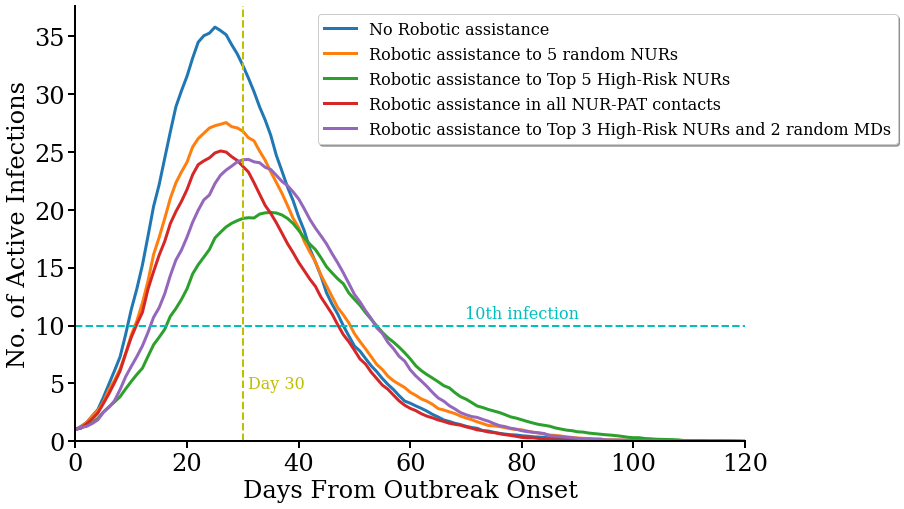

In [ ]:
plt.figure(figsize=(12,8))
plt.rc('font', family='serif')
hfont = {'fontname':'serif', 'fontsize':24}
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(2)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(length=7, width=2)

plt.plot(total_infection_days1, lw=3, label="No Robotic assistance")
plt.plot(total_infection_days2, lw=3, label="Robotic assistance to 5 random NURs")
plt.plot(total_infection_days3, lw=3, label="Robotic assistance to Top 5 High-Risk NURs")
plt.plot(total_infection_days5, lw=3, label="Robotic assistance in all NUR-PAT contacts")
plt.plot(total_infection_days4, lw=3, label="Robotic assistance to Top 3 High-Risk NURs and 2 random MDs")
plt.xlabel('Days From Outbreak Onset', **hfont)
plt.xticks(fontsize=24, fontname='serif')
plt.ylabel('No. of Active Infections', **hfont)
plt.yticks(**hfont)

plt.axhline(y=10, color = 'c', linestyle='--',  lw=2)
plt.axvline(x=30, color = 'y', linestyle='--',  lw=2)
plt.text(80, 11, '10th infection', fontsize=16, va='center', ha='center', color='c')
plt.text(31, 5, 'Day 30', fontsize=16, va='center', ha='left', color='y')
l = plt.legend(bbox_to_anchor=(0.35, 1), fontsize=16, ncol=1, fancybox=True, shadow=True)
plt.setp(l.texts, family='serif')
plt.xlim(0, 120)
plt.ylim(0)

plt.show()